# CUDA编程基础-纹理内存

In [2]:
import pycuda.autoinit
import pycuda.driver as cu
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = str(f.read())
        sm = SourceModule(sources)
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel,sm

In [4]:
sources = string.Template("""
texture<float, cudaTextureType2D, cudaReadModeElementType> texRef;
__global__ void transform_kernel(float * input,float * output,int width,int height,float theta){
    unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    float u = x / (float)width;
    float v = y / (float)height;
    
    // 转换坐标
    u -= 0.5f;
    v -= 0.5f;
    
    float tu = u * cosf(theta) - v * sinf(theta) + 0.5f;
    float tv = v * cosf(theta) + u * sinf(theta) + 0.5f;
    
    int col = tu * width;
    int row = tv * height;
    
    output[y * width + x] = tex2D(texRef,tu,tv);
}

""").substitute()

In [5]:
img = cv2.imread('../../datas/f3.jpg',0)

In [6]:
transform_kernel,sm = load_kernel_from_string(sources,'transform_kernel')
texRef = sm.get_texref('texRef')

In [14]:
dst = np.zeros_like(img).astype(np.float32)
cu.matrix_to_texref(img.astype('float32'), texRef, order="C")

In [15]:
rows,cols = img.shape
block = (32,32,1)
grid = (int((cols + block[0] - 1) / block[0]),int((rows + block[1] - 1) / block[1]),1)
print(block,grid)

(32, 32, 1) (13, 10, 1)


In [26]:
transform_kernel(cu.In(img.astype('float32')),cu.Out(dst),np.int32(cols),
                np.int32(rows),np.float32(30.0 / 180.0 * np.pi),grid=grid,block=block)

In [27]:
print(dst)

[[64. 64. 64. ... 64. 64. 64.]
 [64. 64. 64. ... 64. 64. 64.]
 [64. 64. 64. ... 64. 64. 64.]
 ...
 [86. 86. 86. ... 86. 86. 86.]
 [86. 86. 86. ... 86. 86. 86.]
 [86. 86. 86. ... 86. 86. 86.]]


In [28]:
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = dst.astype('uint8')

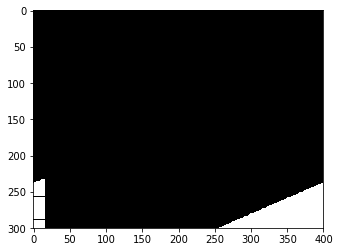

In [29]:
plt.imshow(dst,'gray')

In [19]:
import pycuda.driver as cuda
import pycuda.compiler
import pycuda.autoinit
import numpy
from math import pi,cos,sin

In [50]:
_rotation_kernel_source = """
texture<float, 2> tex;

__global__ void copy_texture_kernel(
    const float resize_val, 
    const float alpha, 
     int oldiw,  int oldih,
     int newiw,  int newih,
     char* data) {

        // calculate pixel idx
        unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;
        unsigned int y = blockIdx.y * blockDim.y + threadIdx.y;
        
        // We might be outside the reachable pixels. Don't do anything
        if( (x >= newiw) || (y >= newih) )
            return;
        
        // calculate offset into destination array
        unsigned int didx = y * newiw + x;
        
        // calculate offset into source array (be aware of rotation and scaling)
        float xmiddle = (x-newiw/2.) / resize_val;
        float ymiddle = (y-newih/2.) / resize_val;
        float sx = ( xmiddle*cos(alpha)+ymiddle*sin(alpha) + oldiw/2.) ;
        float sy = ( -xmiddle*sin(alpha)+ymiddle*cos(alpha) + oldih/2.);
        
        if( (sx < 0) || (sx >= oldiw) || (sy < 0) || (sy >= oldih) ) { 
            data[didx] = 255; 
            return;
        }

        data[didx] = tex2D(tex, sx, sy);
    }
"""

In [52]:
mod_copy_texture=pycuda.compiler.SourceModule( _rotation_kernel_source )

In [53]:
copy_texture_func = mod_copy_texture.get_function("copy_texture_kernel")

In [54]:
texref = mod_copy_texture.get_texref("tex")

In [57]:
def rotate_image( a, resize = 1.5, angle = 20., interpolation = "linear", 
                 blocks = (16,16,1)  ):
    """
    Rotates the array. The new array has the new size and centers the
    picture in the middle.
    
    a             - array (2-dim)
    resize        - new_image w/old_image w
    angle         - degrees to rotate the image
    interpolation - "linear" or None
    blocks        - given to the kernel when run


    returns: a new array with dtype=uint8 containing the rotated image
    """
    angle = angle/180. * pi
    a = a.astype("float32")
    calc_x = lambda x,y :(x*a.shape[1]/2.*cos(angle)-y*a.shape[0]/2.*sin(angle))
    calc_y = lambda x,y :(x*a.shape[1]/2.*sin(angle)+y*a.shape[0]/2.*cos(angle))
    xs = [ calc_x(p[0],p[1]) for p in [ (-1.,-1.),(1.,-1.),(1.,1.),(-1.,1.) ] ]
    ys = [ calc_y(p[0],p[1]) for p in [ (-1.,-1.),(1.,-1.),(1.,1.),(-1.,1.) ] ]
    new_image_dim = (
        int(numpy.ceil(max(ys)-min(ys))*resize),
        int(numpy.ceil(max(xs)-min(xs))*resize),
    )
    
    # Now generate the cuda texture
    cuda.matrix_to_texref(a, texref, order="C")
    # We could set the next if we wanted to address the image
    # in normalized coordinates ( 0 <= coordinate < 1.)
    # texref.set_flags(cuda.TRSF_NORMALIZED_COORDINATES)
    if interpolation == "linear":
        texref.set_filter_mode(cuda.filter_mode.LINEAR)
    
    # Calculate the gridsize. This is entirely given by the size of our image. 
    gridx = new_image_dim[0]//blocks[0] if \
            new_image_dim[0]%blocks[0]==1 else new_image_dim[0]//blocks[0] +1
    gridy = new_image_dim[1]//blocks[1] if \
            new_image_dim[1]%blocks[1]==0 else new_image_dim[1]//blocks[1] +1
    
     # Get the output image
    output = numpy.zeros(new_image_dim,dtype="uint8")
     # Call the kernel
    copy_texture_func(
        numpy.float32(resize), numpy.float32(angle),
        numpy.int32(a.shape[1]), numpy.int32(a.shape[0]),
        numpy.int32(new_image_dim[1]), numpy.int32(new_image_dim[0]),
            cuda.Out(output),texrefs=[texref],block=blocks,grid=(gridx,gridy))
    return output

In [59]:
dst = rotate_image(img,angle=30.0)

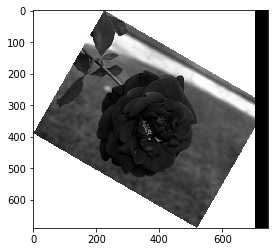

In [61]:
plt.imshow(dst,'gray')